In [44]:
import sys
from pathlib import Path
import pandas as pd 
import numpy as np
import keras
from keras.layers import LSTM, Dense, Dropout, LeakyReLU
from keras.models import Sequential
from keras.preprocessing.sequence import TimeseriesGenerator
sys.path.append(str(Path("../../..").resolve()))
from src.constants import model_data_dir


In [68]:
df_train = pd.read_csv(model_data_dir / "train_regression.csv").drop(["Date", "sc_1d_fwd_rel_ret", "mom_1d_fwd_rel_ret"], axis=1)
df_test = pd.read_csv(model_data_dir / "test_regression.csv").drop(["sc_1d_fwd_rel_ret", "mom_1d_fwd_rel_ret"], axis=1)
test_dates = pd.to_datetime(df_test["Date"])
df_test.drop("Date", axis=1, inplace=True)

In [35]:
((y_train, x_train), (y_test, x_test)) = ((df_train.pop("value_1d_fwd_rel_ret"), df_train), (df_test.pop("value_1d_fwd_rel_ret"), df_test))

In [81]:
win_length = 30
batch_size = 90
num_features = x_train.shape[1]
train_generator = TimeseriesGenerator(x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)


In [82]:
model = Sequential()
model.add(LSTM(128, input_shape= (win_length, num_features), return_sequences=True))
model.add(LeakyReLU(alpha=0.5)) 
model.add(LSTM(128, return_sequences=True))
model.add(LeakyReLU(alpha=0.5)) 
model.add(Dropout(0.3)) 
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3)) 
model.add(Dense(1))

In [83]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 30, 128)           115712    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 30, 128)           0         
                                                                 
 lstm_8 (LSTM)               (None, 30, 128)           131584    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 30, 128)           0         
                                                                 
 dropout_4 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_5 (Dropout)         (None, 64)               

In [84]:
model.compile(loss=keras.losses.MeanSquaredError(),
              optimizer="adam",
              metrics=[keras.metrics.MeanAbsoluteError()])

history = model.fit_generator(train_generator, epochs=50,
                    validation_data=test_generator,
                    shuffle=False,)

Epoch 1/50


/var/folders/r2/ycy8hp_54yd7bxc_0kyb5trm0000gn/T/ipykernel_20178/2311332047.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, epochs=50,


38/38 [==============================] - 13s 155ms/step - loss: 0.0096 - mean_absolute_error: 0.0550 - val_loss: 1.6515e-04 - val_mean_absolute_error: 0.0122
Epoch 2/50
38/38 [==============================] - 4s 118ms/step - loss: 1.7630e-04 - mean_absolute_error: 0.0104 - val_loss: 1.8691e-05 - val_mean_absolute_error: 0.0030
Epoch 3/50
38/38 [==============================] - 4s 105ms/step - loss: 9.1839e-05 - mean_absolute_error: 0.0076 - val_loss: 1.8419e-05 - val_mean_absolute_error: 0.0029
Epoch 4/50
38/38 [==============================] - 4s 117ms/step - loss: 7.5900e-05 - mean_absolute_error: 0.0069 - val_loss: 1.8004e-05 - val_mean_absolute_error: 0.0029
Epoch 5/50
38/38 [==============================] - 5s 120ms/step - loss: 6.1615e-05 - mean_absolute_error: 0.0062 - val_loss: 1.7963e-05 - val_mean_absolute_error: 0.0029
Epoch 6/50
38/38 [==============================] - 4s 108ms/step - loss: 4.9957e-05 - mean_absolute_error: 0.0056 - val_loss: 1.8084e-05 - val_mean_absol

In [85]:
predictions = model.predict_generator(test_generator)
df_preds = pd.DataFrame({"ds": test_dates[win_length:], "y": y_test[win_length:], })
df_preds["yhat"] = predictions.flatten()

/var/folders/r2/ycy8hp_54yd7bxc_0kyb5trm0000gn/T/ipykernel_20178/953353012.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator)


<AxesSubplot:>

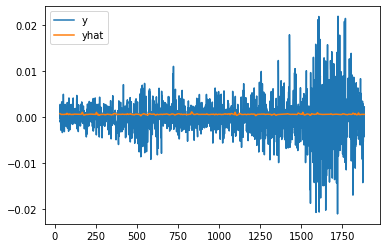

In [86]:
df_preds[["y", "yhat"]].plot()